## Data flow : from raw lightcurves to merged metrics 

A notebook to plot : 

    1) color - magnitude (Hess) diagrams 
    
    2) color - color diagrams 
   
We use the Stripe 82 reprocessed FP data, from two processing centers : NCSA and IN2P3. Each got a half of the S82 coverage, with a narrow overlapping region of 0.5 degrees. 

On typhoon,  I ssh'd to magneto ,  and used the lightcurves in 
    
    /astro/store/pogo4/s13_stripe82/forced_phot_lt_23/NCSA/
    /astro/store/pogo4/s13_stripe82/forced_phot_lt_23/IN2P3/
   
to reprocess them using code LC_processing.py  , stored in : 
    
    mac : /Users/chris/GradResearch/SDSS_S82_FP_research/code/
    typhoon: /astro/users/suberlak/SDSS_S82_FP_research/code/
    
which uses processPatch.py package, stored in :

    mac : /Users/chris/GradResearch/SDSS_S82_FP_research/packages/
    typhoon: /astro/users/suberlak/SDSS_S82_FP_research/packages/
    
    
The output are metrics calculated per lightcurve per band, stored in:

    /astro/store/scratch/tmp/suberlak/s13_S82_2017/NCSA/
    /astro/store/scratch/tmp/suberlak/s13_S82_2017/IN2P3/
    
Then using code VarStat_merge_ugriz.py, from 
    mac : /Users/chris/GradResearch/SDSS_S82_FP_research/code/
    typhoon: /astro/users/suberlak/SDSS_S82_FP_research/code/
  
all metrics are  merged on 'objectId' ,  correctiong for extinction with  
    typhoon : /astro/users/suberlak/Desktop/deep_source/ebv_NCSA_lt235.dat
    
with information on  ra, dec, extendedness,from DeepSource files:

    typhoon : /astro/users/suberlak/Desktop/deep_source/DeepSourceIN2P3_i_lt235_extendedness.csv.gz
                                                        DeepSourceIN2P3_i_lt235_narrow.csv.gz

and removing from the combined files objects that have parents brighter than 17th mag ( in coadd i-band) from NCSA_source_without_bright_parent.npy , which was made using 

    source : DeepSourceNCSA_i_lt235_narrow.csv.gz and
    parent : DeepSourceNCSA_i_lt235_narrow_not_primary.csv.gz
    (analogous for IN2P3) 
 

To make output files smaller, we save only  N, chi2dof, chi2R, mu_full, psfMeanErr, psfMean_corr, ebv, pathch, objectId, ra,dec, extendedness in the final combined files ('narrow files'), stored in : 

    /astro/store/scratch/tmp/suberlak/s13_S82_2017/NCSA/varMetricsMerged/
    /astro/store/scratch/tmp/suberlak/s13_S82_2017/IN2P3/varMetricsMerged/
    
with a local copy of NCSA merged file at 

    /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/varMetricsMerged/
    

**README** (originally from  /astro/store/pogo4/s13_stripe82/deep_source/) : 
    
"Sources detected and measured on the i-band coadds with i-band psfMag < 23.5.

All reported row counts do not include the header.

The two data release productions (DRPs) overlap by 2.5 x 5 sq. deg. for validation purposes.
1) NCSA (-40  < RA < 10): 5,474,350 primary rows with psfMag < 23.5
2) IN2P3 (5 < RA < 55):   4,998,901 primary rows with psfMag < 23.5

Note that the imaging processed at the two datacenters was completed independently.
Therefore, DEEPSOURCEIDs ARE UNIQUE TO A DRP!
WITHIN a DRP, the i-band deepSourceId is the key across files as it was the SEED for forced photometry.


Files in this directory:
* DeepSourceNCSA_i_lt235.csv:        "Primary" sources. 60 columns x 5474350 rows
* DeepSourceNCSA_i_lt235_narrow.csv: "Primary" sources with subset of 10 columns x 5474350 rows
* DeepSourceNCSA_i_lt235_narrow_not_primary.csv: "Not-Primary" sources. 1957486 rows
        These are deblender parents and secondary detections in overlap regions.


* DeepSourceIN2P3_i_lt235.csv:        "Primary" sources. 60 columns x 4998901 rows
* DeepSourceIN2P3_i_lt235_narrow.csv: "Primary" sources with subset of 10 columns x 4998901 rows
* DeepSourceIN2P3_i_lt235_narrow_not_primary.csv: "Not-Primary" sources. 1882303 rows
        These are deblender parents and secondary detections in overlap regions. 


* ebv_IN2P3_lt235.dat: deepSourceId and ebv for primary IN2P3 sources 4998901 rows
* ebv_NCSA_lt235.dat:  deepSourceId and ebv for primary NCSA sources 5474350 rows

File notes:
If parentDeepSourceId == -1, it is null and the deep source did not have a parent.
BEWARE: sources with parents with i < 17 have unreliable lightcurves and morphologies. 
I recommend removing from survey like:
######## EXAMPLE #######
import pandas as pd
source = pd.read_csv('DeepSourceNCSA_i_lt235_narrow.csv.gz', compression='gzip', index_col=0)
parent = pd.read_csv('DeepSourceNCSA_i_lt235_narrow_not_primary.csv.gz', compression='gzip', index_col=0)
parent_bright = parent.loc[parent.psfMag < 17.0]
parent_source_joined = pd.merge(source, parent_bright[['psfMag', 'psfMagSigma', 'ra', 'decl']],
                         how='left', suffixes=['', '_parent'],
                         left_on='parentDeepSourceId', right_index=True)
source_without_bright_parent = parent_source_joined.loc[parent_source_joined.psfMag_parent.isnull()]
###############################

Questions? email yusra@uw.edu"

## Imports 

In [18]:
import pandas as pd
pd.options.display.max_columns = 999

import numpy as np
import os 
import sys
import matplotlib.pyplot as plt 
from scipy.stats import binned_statistic_2d
from astropy.table import Table
import datetime

## Read-in the ugriz variability metrics

In [3]:
# NCSA 
# using astropy Table : discussion about speed 
# https://github.com/astropy/astropy/issues/3334 

# In the last resort : line-by-line ascii approach
# http://hea-www.harvard.edu/~aldcroft/tmp/p4a/hamogu/html/files/asciifiles.html
    
DirIn = '../data_products/varMetricsMerged/'
fname =  'Var_ugriz_11_patches_NCSA_narrow.csv' 
data1 = Table.read(DirIn+fname, format='csv')

In [55]:
# IN2P3
DirIn = '../data_products/varMetricsMerged/'
fname =  'Var_ugriz_11_patches_IN2P3_narrow.csv.gz' 
data2 = Table.read(DirIn+fname, format='csv')

In [63]:
# stack the two vertically 
from astropy.table import vstack

data = vstack([data1, data2])

In [66]:
#data

In [64]:
# Read in the single patch combined across filters...
# Pandas hangs up if I try anything > 1 mln rows ....

#DirIn = '../data_products/varMetricsMerged/'
#fname =  'Var_ugriz_11_patches_NCSA_narrow.csv' #'Var_ugriz_1_patches_NCSA.csv.gz'
#data = pd.read_csv( DirIn + fname,low_memory=False, nrows=2e6)

## Plotting ...

### Sesar 2007 , Fig.3 

In [31]:
figDir = 'Fig_Sesar2007'
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+figDir,
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)

We will save this figure in  /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-10/


In [22]:
# Select objects with chi2DOF > 3 ,  and plot  g vs u-g  ,  g-r  vs u-g 
# also plot chi2DOF  vs chi2R ...

# code needed for that is already present in 
# VarStat_exploratory_ugriz_results.ipynb   


In [122]:
import matplotlib.pyplot as plt
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 13

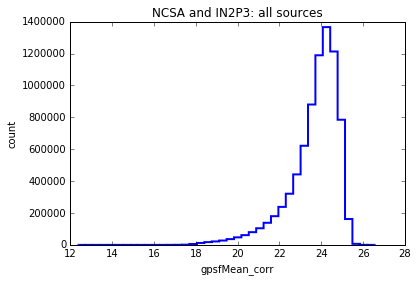

In [68]:
# show how magnitude cuts affect our numbers... 
plt.hist(data['gpsfMean_corr'], bins=40, histtype='step', lw=2)
plt.title('NCSA and IN2P3: all sources')
plt.xlabel('gpsfMean_corr')
plt.ylabel('count')

Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-10/Fig3_test.png 


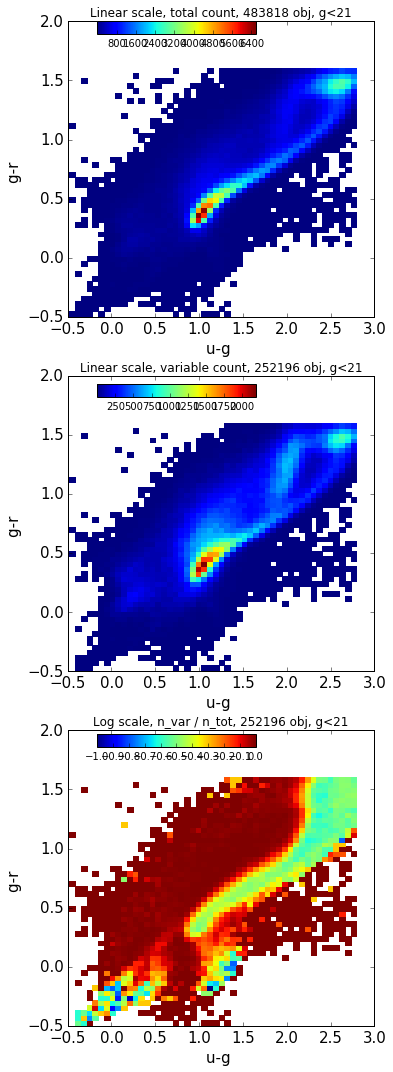

In [71]:
%matplotlib inline

# Note : 
# when using astropy, instead of .values
# need to call .data.data .... 
# If need to use pandas,  make sure you do Edit --> Find and Replace ! 

u = data['upsfMean_corr'].data.data
g = data['gpsfMean_corr'].data.data
r = data['rpsfMean_corr'].data.data
ug = u - g
gr = g - r

gmax = 21.5

mask_brightness = g < gmax
mask_ug = ((u-g)<2.8) & ((u-g)>-0.5)
mask_gr = ((g-r)<1.6) & ((g-r)>-0.5)
mask_n_points_g = (data['gN'].data.data > 60) & (data['gN'].data.data < 160)
mask_n_points_r = (data['rN'].data.data > 60) & (data['rN'].data.data < 160)
mask_n_points_u = (data['uN'].data.data > 60) & (data['uN'].data.data < 160)
mask_n_points = mask_n_points_u & mask_n_points_g & mask_n_points_r
mask_total = mask_ug & mask_gr & mask_brightness & mask_n_points

fig, ax = plt.subplots(3,1, figsize=(5.5,18))

############################
# TOP PANEL :  TOTAL COUNT #
############################

nObj = len(u[mask_total])
stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                            values=ug[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

# Plot 2D histogram using pcolor
image = ax[0].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')
ax[0].set_xlabel('u-g ', fontsize=15)
ax[0].set_ylabel('g-r ', fontsize=15)
ax[0].set_title('Linear scale, total count, %d obj, g<%d'%(nObj,gmax))
ax[0].tick_params(axis='both', which='major', labelsize=15) 

colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])
colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')
#ticks = colorbar.ax.get_xticks()
#colorbar.set_ticks(ticks[::2])
#colorbar.set_ticks([0.5,1,1.5])
#colorbar.set_ticklabels(['0.5','1', '1.5'])

####################################
# MIDDLE PANEL :  VARIABLE COUNT   #
####################################

# select variable objects... 
mask_chi2_g = data['gchi2DOF'].data.data > 1 + 3*np.sqrt(2.0/data['gN'].data.data)
mask_chi2_r = data['rchi2DOF'].data.data > 1 + 3*np.sqrt(2.0/data['rN'].data.data)
mask_combined = mask_chi2_g & mask_chi2_r 

mask_variable = mask_total & mask_combined
nObj = len(u[mask_variable])

# Calculate the count of variable sources...
stats = binned_statistic_2d(x=ug[mask_variable], y=gr[mask_variable], values=ug[mask_variable], 
                            statistic='count', bins=50)
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked_var = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor
image = ax[1].pcolormesh(x_edges,y_edges,z_masked_var, cmap='jet')
ax[1].set_xlabel('u-g ', fontsize=15)
ax[1].set_ylabel('g-r ', fontsize=15)
ax[1].set_title('Linear scale, variable count, %d obj, g<%d'%(nObj,gmax))
ax[1].tick_params(axis='both', which='major', labelsize=15) 
colorbar_ax = fig.add_axes([0.2, 0.61, 0.4, 0.01])
colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')

###################################################
# BOTTOM PANEL :  VARIABLE COUNT / TOTAL COUNT    #
###################################################

z_masked_ratio = z_masked_var / z_masked
# Mask pixels with a value of zero

# Plot 2D histogram using pcolor
Z =  np.log10(z_masked_ratio)
image = ax[2].pcolormesh(x_edges,y_edges, Z, cmap='jet', vmax = 0)
ax[2].set_xlabel('u-g ', fontsize=15)
ax[2].set_ylabel('g-r ', fontsize=15)
ax[2].set_title('Log scale, n_var / n_tot, %d obj, g<%d'%(nObj,gmax))
ax[2].tick_params(axis='both', which='major', labelsize=15) 

colorbar_ax = fig.add_axes([0.2, 0.34, 0.4, 0.01])
colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')
mn=int(np.floor(Z.min()))        # colorbar min value
mx=int(np.ceil(Z.max()))         # colorbar max value
md = (mx-mn)/2                     # colorbar midpoint value
#colorbar.set_ticks([mn,md,mx])
#colorbar.set_ticklabels([mn,md,mx])



#plt.tight_layout()

# Saving the colorbar from being messed by the tight_layout()
# http://matplotlib.org/users/tight_layout_guide.html

fname = outDir+'Fig3_test.png'
plt.savefig(fname)
print('Saved as %s '%fname)


### Sesar 2007 , Fig.4

Saved as /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-10/Fig4_test.png 


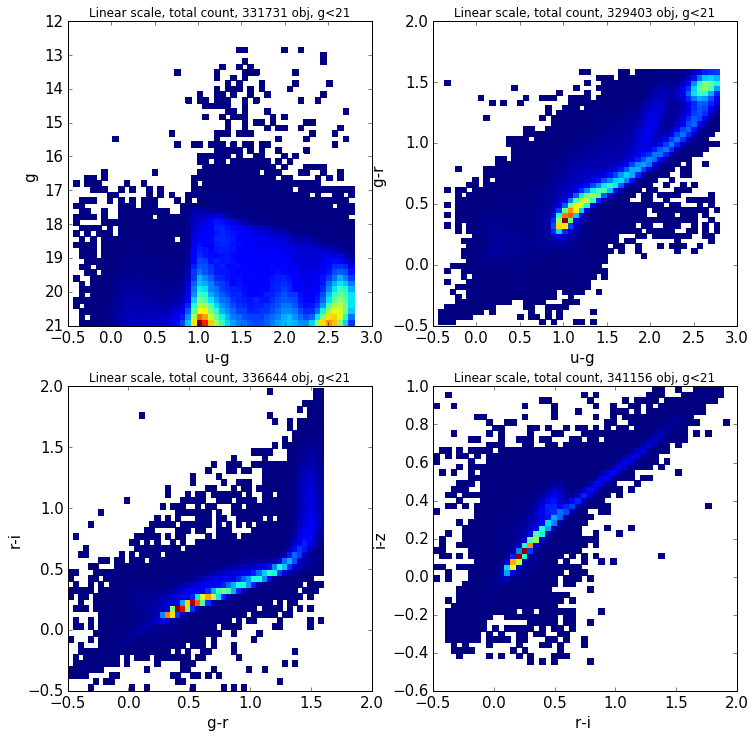

In [72]:
%matplotlib inline
u = data['upsfMean_corr'].data.data
g = data['gpsfMean_corr'].data.data
r = data['rpsfMean_corr'].data.data
i = data['ipsfMean_corr'].data.data
z = data['zpsfMean_corr'].data.data

ug = u-g
gr = g-r
ri = r-i
iz = i-z

# limits below based on Sesar 2007 Fig.4
gmax = 21
mask_g = g < gmax
mask_ug = ((ug)<2.8) & ((ug)>-0.5)
mask_gr = ((gr)<1.6) & ((gr)>-0.5)
mask_ri = ((ri)<2.0) & ((ri)>-0.5)
mask_iz = ((iz)<1.0) & ((iz)>-0.5)

# use some variability measure...


fig, axs = plt.subplots(2,2, figsize=(12,12))
ax = np.ravel(axs)


# TOP_LEFT  : g vs u-g  
mask_total = mask_g  & mask_ug
nObj = len(g[mask_total])
stats = binned_statistic_2d(x=ug[mask_total], y=g[mask_total], 
                            values=ug[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

# Plot 2D histogram using pcolor
image = ax[0].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')
ax[0].set_xlabel('u-g ', fontsize=15)
ax[0].set_ylabel('g ', fontsize=15)
ax[0].set_title('Linear scale, total count, %d obj, g<%d'%(nObj,gmax))
ax[0].tick_params(axis='both', which='major', labelsize=15) 
ax[0].invert_yaxis()
#colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')


# TOP_RIGHT  : u-g vs g-r
mask_total = mask_g & mask_gr  & mask_ug
nObj = len(gr[mask_total])
stats = binned_statistic_2d(x=ug[mask_total], y=gr[mask_total], 
                            values=ug[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

# Plot 2D histogram using pcolor
image = ax[1].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')
ax[1].set_xlabel('u-g ', fontsize=15)
ax[1].set_ylabel('g-r ', fontsize=15)
ax[1].set_title('Linear scale, total count, %d obj, g<%d'%(nObj,gmax))
ax[1].tick_params(axis='both', which='major', labelsize=15) 
#ax[0].invert_yaxis()
#colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')


# BOTTOM_LEFT :  g-r vs r-i
mask_total = mask_g & mask_gr  & mask_ri
nObj = len(gr[mask_total])
stats = binned_statistic_2d(x=gr[mask_total], y=ri[mask_total], 
                            values=gr[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

# Plot 2D histogram using pcolor
image = ax[2].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')
ax[2].set_xlabel('g-r ', fontsize=15)
ax[2].set_ylabel('r-i', fontsize=15)
ax[2].set_title('Linear scale, total count, %d obj, g<%d'%(nObj,gmax))
ax[2].tick_params(axis='both', which='major', labelsize=15) 
#ax[0].invert_yaxis()
#colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')



# BOTTOM_RIGHT :   r-i vs i-z
mask_total = mask_g & mask_iz  & mask_ri
nObj = len(ri[mask_total])
stats = binned_statistic_2d(x=ri[mask_total], y=iz[mask_total], 
                            values=ri[mask_total], statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

# Plot 2D histogram using pcolor
j = 3
image = ax[j].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')
ax[j].set_xlabel('r-i ', fontsize=15)
ax[j].set_ylabel('i-z', fontsize=15)
ax[j].set_title('Linear scale, total count, %d obj, g<%d'%(nObj,gmax))
ax[j].tick_params(axis='both', which='major', labelsize=15) 
#ax[0].invert_yaxis()
#colorbar_ax = fig.add_axes([0.2, 0.89, 0.4, 0.01])
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')

fname = outDir+'Fig4_test.png'
plt.savefig(fname)
print('Saved as %s '%fname)






## Plot    $\chi^{2}_{DOF}$   vs   $\chi^{2}_{R}$

In [103]:

#data[f+'chi2R']


In u filter, 
There are 7961043 objects total
Of these: 7961043 are not NaNs
          7939941 have chi2dof<10 and chi2R < 10 
          1720496 have gpsfMean_corr < 23 
These 3 criteria are simultaneously met by 1705961 objects, 
from which 668182 satisfy chi2dof > 1+3 sqrt(2/N) 

In g filter, 
There are 7961043 objects total
Of these: 7961043 are not NaNs
          7653553 have chi2dof<10 and chi2R < 10 
          1720496 have gpsfMean_corr < 23 
These 3 criteria are simultaneously met by 1501834 objects, 
from which 977252 satisfy chi2dof > 1+3 sqrt(2/N) 

In r filter, 
There are 7961043 objects total
Of these: 7961043 are not NaNs
          7487647 have chi2dof<10 and chi2R < 10 
          1720496 have gpsfMean_corr < 23 
These 3 criteria are simultaneously met by 1354896 objects, 
from which 838492 satisfy chi2dof > 1+3 sqrt(2/N) 

In i filter, 
There are 7961043 objects total
Of these: 7961043 are not NaNs
          7458026 have chi2dof<10 and chi2R < 10 
          1720496 have 

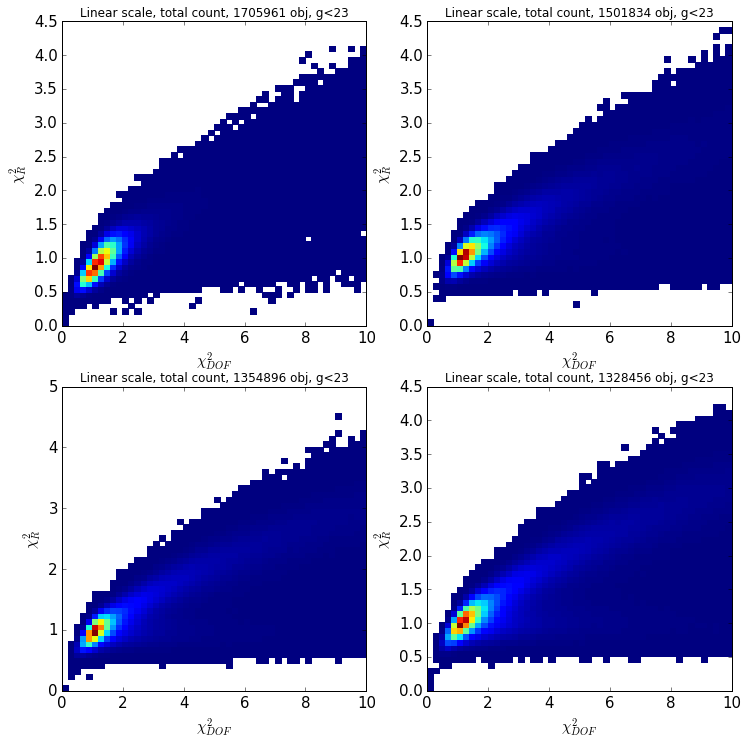

In [73]:
filters = 'ugri'

fig, axs = plt.subplots(2,2, figsize=(12,12))
ax = np.ravel(axs)
gmax = 23

for j in range(len(filters)):
    f = filters[j]
    stdev = np.sqrt(2.0 / data[f+'N'])
    chi2dof = data[f+'chi2DOF'].data.data
    chi2R = data[f+'chi2R'].data.data
    m1 = (~np.isnan(chi2dof))&(~np.isnan(chi2R))
    m2 = (chi2dof < 10) & (chi2R < 10 )
    m3 = data['gpsfMean_corr'].data.data < gmax 
    
    m = m1 & m2 &m3
    mask_chi2dof = chi2dof[m] > 1 +  3 * stdev[m]
    print('\nIn %s filter, '%f )
    print('There are %d objects total'%len(chi2dof))
    print('Of these: %d are not NaNs'%np.sum(m1))
    print('          %d have chi2dof<10 and chi2R < 10 '% np.sum(m2))
    print('          %d have gpsfMean_corr < %d '% (np.sum(m3), gmax))
    print('These 3 criteria are simultaneously met by %d objects, '%np.sum(m))
    print('from which %d satisfy chi2dof > 1+3 sqrt(2/N) '%np.sum(mask_chi2dof))
    
    nObj = len(chi2dof[m])
    stats = binned_statistic_2d(x=chi2dof[m], y=chi2R[m], 
                            values=chi2dof[m], statistic='count', bins=50)

    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

    # Plot 2D histogram using pcolor
    image = ax[j].pcolormesh(x_edges,y_edges,z_masked, cmap='jet')
    ax[j].set_xlabel(r'$\chi^{2}_{DOF}$', fontsize=15)
    ax[j].set_ylabel(r'$\chi^{2}_{R}$', fontsize=15)
    ax[j].set_title('Linear scale, total count, %d obj, g<%d'%(nObj,gmax))
    ax[j].tick_params(axis='both', which='major', labelsize=15) 




## RA vs DEC coverage... 

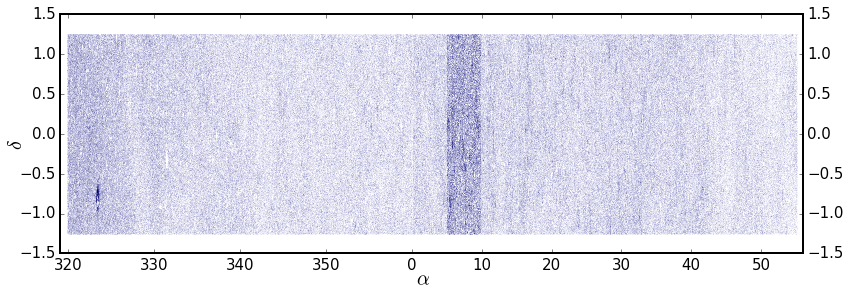

In [151]:
m1 = data['gpsfMean_corr'] < gmax 


#fig,ax = plt.subplots(1,2,figsize=(12,4), sharey = True)



import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(12,4 ))

ax = dict()
number_of_rows  = 1 
number_of_columns = 19  # because I have 320:360, and then 0:55 degrees, which in total spans 
# 40 on the left,  and 55 on the right , 
# 40:55 = 8:11,  8+11 = 19 will give the right aspect ratio 
gs = gridspec.GridSpec(number_of_rows,  number_of_columns)
#ax = plt.subplot(gs[rowspan, colspan])
ax[0] = plt.subplot(gs[:, :9])  # span all rows but the last one (bottom), and first 5 col
ax[1] = plt.subplot(gs[:, 9:])  # span all rows but the last one (bottom), and last 5 cols

fig.subplots_adjust(wspace=0)

dotsize = 0.02

# left part 
m2 = data['ra'] > 60
m = m1 & m2 
ax[0].scatter(data['ra'][m], data['decl'][m], lw=0, s=dotsize)
ax[0].set_xlim(319, 360)
ax[0].yaxis.set_ticks_position('left')
xticks = ax[0].get_xticks()
ax[0].set_xticks(xticks[:-1][1::2])
# right part 
m2 = data['ra'] < 60
m = m1 & m2 
ax[1].scatter(data['ra'][m], data['decl'][m], lw=0, s=dotsize)
ax[1].set_xlim(0,56)

ax[1].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].yaxis.set_ticks_position('right')

#ax[0].set_ylabel(r'$\delta$')
#fig.set_label('RA')
#a
Xlabel = r'$\alpha$'
Ylabel = r'$\delta$'
fig.text(0.5, 0.03, Xlabel, ha='center', va='center', fontsize=20)
fig.text(0.03, 0.5, Ylabel, ha='center', va='center', rotation='vertical', fontsize=20)

fig.subplots_adjust(wspace=0, hspace=0.36, left=0.08, right=0.94, bottom=0.12, top=0.95)
plt.savefig('../data_products/Fig_ra_dec/Fig_radec_test_g_lt'+str(gmax)+'.png')

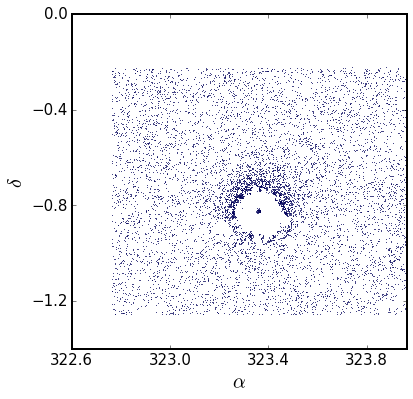

In [179]:
# zoom -in on the region with some structure ....
gmax = 22
m2_ra = 323.36258
m2_dec  = -0.82325

m1 = data['gpsfMean_corr'] < gmax

margin = 0.6 # degree 
m2 = ( m2_ra - margin < data['ra'] ) & ( data['ra'] < m2_ra + margin)
m3 = (data['decl'] < m2_dec + margin) & (data['decl'] > m2_dec-margin)
m = m1 & m2 & m3 

fig,ax = plt.subplots(figsize=(6,6))
ax.scatter(data['ra'][m], data['decl'][m], lw=0, s=0.6)
ax.set_xlim(m2_ra - margin,  m2_ra + margin)

xticks = ax.get_xticks()
ax.set_xticks(xticks[::2])

yticks = ax.get_yticks()
ax.set_yticks(yticks[2::2])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\delta$')

plt.savefig('../data_products/Fig_ra_dec/Fig_radec_zoom_M2_cluster.png')

## Fig. 23 : g-i vs r 

j=0
j=1
j=2
j=3
j=0
j=1
j=2
j=3


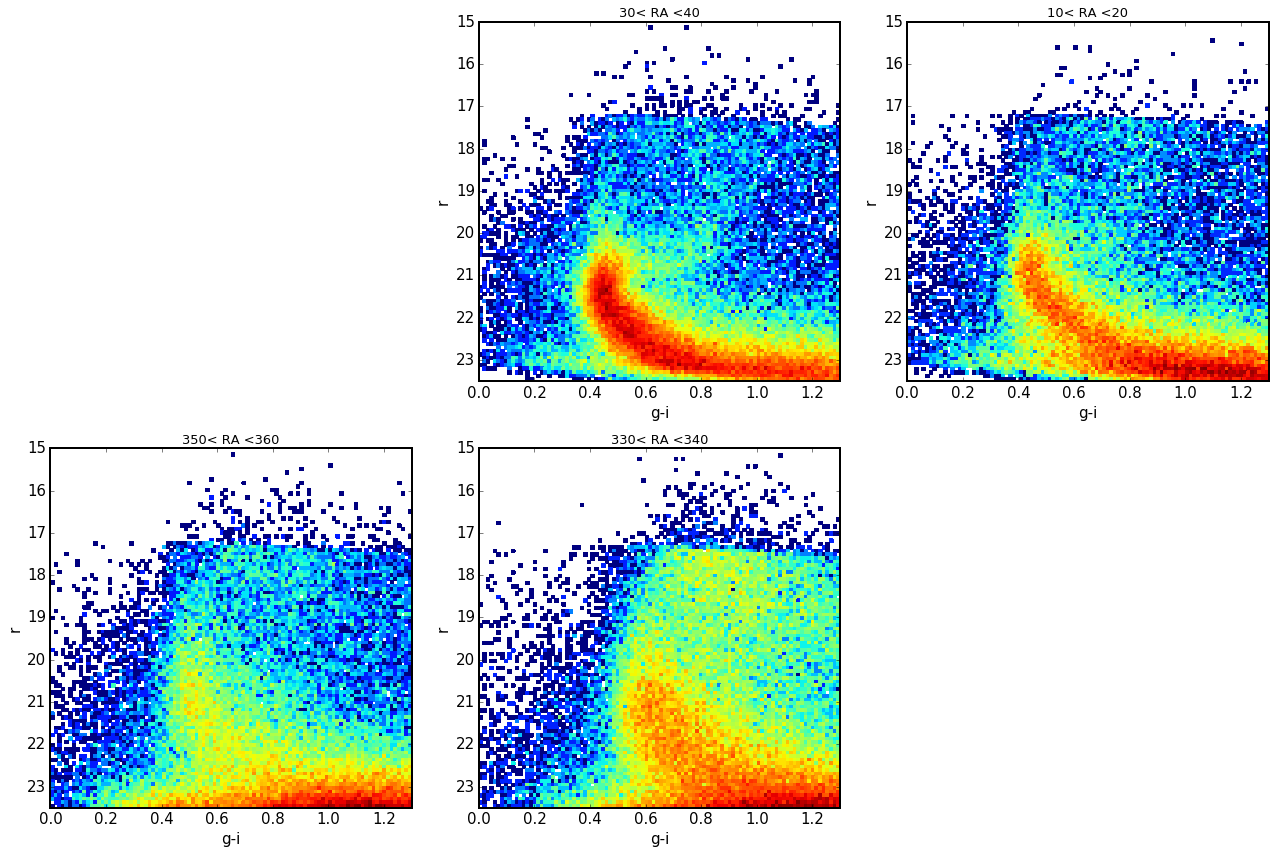

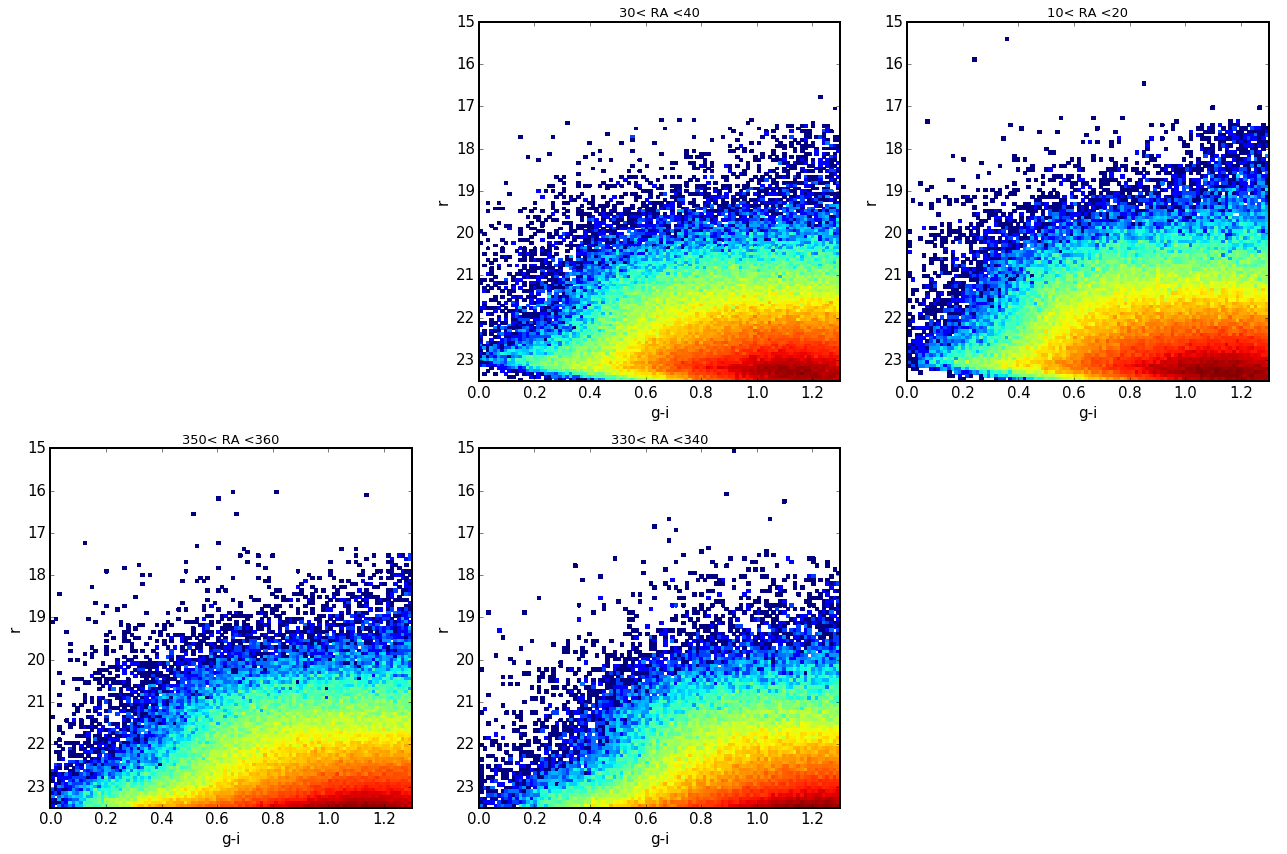

In [182]:
# make the plot ... 
raMin = [30, 10, 350,330]
raMax = [40, 20, 360,340]


#####   g-i vs r (like Fig.23)   

# Select a range of gi,  r  for the histogram....  
gi_lim = [0,1.3]
r_lim = [15,23.5] 
#nbinsArr = [100,100,50]

nbins = 100

for i in range(2):
    ext=i # choose extendedness 
    fig, axs = plt.subplots(2,3, figsize=(18,12))
    ax = np.ravel(axs) 

    for j in range(len(raMin)):
        print('j=%d'%j)
        maskRa =  (raMin[j] < data['ra'])  & (data['ra'] < raMax[j])
        maskExtend = data['extendedness'] == ext
        maskTot = maskRa * maskExtend
        gi = data['gpsfMean_corr'][maskTot] - data['ipsfMean_corr'][maskTot]
        r =  data['rpsfMean_corr'][maskTot]
        maskCol = (gi < gi_lim[1])&(gi>gi_lim[0])&(r<r_lim[1])&(r > r_lim[0])
        H, xedges, yedges = np.histogram2d(gi[maskCol],r[maskCol],bins=nbins)
        # H needs to be rotated and flipped
        H = np.rot90(H)
        H = np.flipud(H)
        # Mask zeros
        Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zeropltssssss
        # Plot 2D histogram using pcolor
        ax[j+1].pcolormesh(xedges,yedges,np.log10(Hmasked), cmap='jet')
        ax[j+1].set_xlabel('g-i', fontsize=15)
        ax[j+1].set_ylabel('r', fontsize=15)
        ax[j+1].set_xlim(gi_lim[0],gi_lim[1])
        ax[j+1].set_ylim(r_lim[0], r_lim[1])
        ax[j+1].set_title(str(raMin[j])+'< RA <' + str(raMax[j]))
        ax[j+1].invert_yaxis()
        
        ax[j+1].tick_params(axis = 'both', labelsize=15) 
    ax[0].axis('off')
    ax[5].axis('off')
    plt.tight_layout()
    plt.savefig('../data_products/Fig_Sesar2010/Fig_23_test_ext-'+str(ext)+'.png')

## Fig. 23- like : g-r vs r-i 

In [190]:
raMin = [320, 330, 340,350,0, 10,20,30,40]
raMax = [330, 340, 350,360,10,20,30,40,55]

# Select a range of r-i,  g-r  for the histogram.... 
xlim = [-1,3]
ylim = [-1,3]

mag_lims = [5,19.0,19.2,19.4,19.6,19.8, 20.0, 20.2, 20.4, 20.6, 20.8,
            21.0, 21.2, 21.4, 21.6, 21.8, 22.0, 22.4,22.6,22.8,23,23.2,23.4,23.6,24]
#mag_lims = [22.0, 22.4, 22.6]
dir_save = '../data_products/Fig_Sesar2010/'

nbins = 100
count=0
for i in range(2):
    ext=i # choose extendedness 
    print('extendedness=%d'%ext)

    for k in range(len(mag_lims)-1):
        mask_band = (mag_lims[k] < data['ipsfMean_corr']) & (data['ipsfMean_corr'] < mag_lims[k+1])
        print('i_mag_min=%.2f, i_mag_max=%.2f'%(mag_lims[k], mag_lims[k+1]))
        # make a plot for each extendedness and mag range 
        count+=1
        fig, axs = plt.subplots(3,3, figsize=(12,12))
        ax = np.ravel(axs) 

        for j in range(len(raMin)):
            #print('j=%d'%j)
            mask_ra =  (raMin[j] < data['ra'])  & (data['ra'] < raMax[j])
            mask_extendedness = data['extendedness'] == ext

            mask_total = mask_ra & mask_extendedness & mask_band
            ri = data['rpsfMean_corr'][mask_total] - data['ipsfMean_corr'][mask_total]
            gr = data['gpsfMean_corr'][mask_total] - data['rpsfMean_corr'][mask_total]
            #grri = pd.concat([gr,ri], axis=1)
            #grri_dropna = grri.dropna()
            #gr = grri_dropna[0]
            #ri = grri_dropna[1]
            maskCol = (gr < xlim[1])&(gr>xlim[0])&(ri<ylim[1])&(ri>ylim[0])
            H, xedges, yedges = np.histogram2d(gr[maskCol],ri[maskCol],bins=nbins)
            #H, xedges, yedges = np.histogram2d(grri_dropna[1],grri_dropna[0],bins=nbins)
            # H needs to be rotated and flipped
            H = np.rot90(H)
            H = np.flipud(H)
            # Mask zeros
            Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
            # Plot 2D histogram using pcolor
            ax[j].pcolormesh(xedges,yedges,np.log10(Hmasked), cmap='jet')
            #ax[j].set_ylabel('r-i', fontsize=15)
            #ax[j].set_xlabel('g-r', fontsize=15)
            ax[j].set_xlim(xlim[0],xlim[1])
            ax[j].set_ylim(ylim[0],ylim[1])
            ax[j].set_title(str(raMin[j])+'< RA <' + str(raMax[j]))
            #ax[j].invert_yaxis()
            ax[j].tick_params(axis = 'both', labelsize=15) 

        #fig.subplots_adjust(wspace=0, hspace=0, left=0.1, bottom=0.20, top=0.95)

        #ax[j+1].axis('off')
        fig.text(0.5, 0.96, 'Extendedness='+str(ext)+' , '+str(mag_lims[k])+' < iPsfMean < '+str(mag_lims[k+1]), ha='center', va='center',fontsize=20)
        fig.text(0.5, 0.04, 'g-r', ha='center', va='center',fontsize=20)
        fig.text(0.03, 0.5, 'r-i', ha='center', va='center', rotation='vertical',fontsize=20)

        fig.tight_layout()
        fig.subplots_adjust(wspace=0.26, hspace=0.26, left=0.12, right=0.94, bottom=0.10, top=0.9)
        figname =  dir_save+ 'Fig_23_like_test'+str(count).zfill(2)+'_Fig_g-r_vs_r-i_ext_'+\
                    str(ext)+'_'+str(mag_lims[k])+'-i-'+str(mag_lims[k+1])+'.png'
        plt.savefig(figname)
        plt.close(fig)



extendedness=0
i_mag_min=5.00, i_mag_max=19.00
i_mag_min=19.00, i_mag_max=19.20
i_mag_min=19.20, i_mag_max=19.40
i_mag_min=19.40, i_mag_max=19.60
i_mag_min=19.60, i_mag_max=19.80
i_mag_min=19.80, i_mag_max=20.00
i_mag_min=20.00, i_mag_max=20.20
i_mag_min=20.20, i_mag_max=20.40
i_mag_min=20.40, i_mag_max=20.60
i_mag_min=20.60, i_mag_max=20.80
i_mag_min=20.80, i_mag_max=21.00
i_mag_min=21.00, i_mag_max=21.20
i_mag_min=21.20, i_mag_max=21.40
i_mag_min=21.40, i_mag_max=21.60
i_mag_min=21.60, i_mag_max=21.80
i_mag_min=21.80, i_mag_max=22.00
i_mag_min=22.00, i_mag_max=22.40
i_mag_min=22.40, i_mag_max=22.60
i_mag_min=22.60, i_mag_max=22.80
i_mag_min=22.80, i_mag_max=23.00
i_mag_min=23.00, i_mag_max=23.20
i_mag_min=23.20, i_mag_max=23.40
i_mag_min=23.40, i_mag_max=23.60
i_mag_min=23.60, i_mag_max=24.00
extendedness=1
i_mag_min=5.00, i_mag_max=19.00
i_mag_min=19.00, i_mag_max=19.20
i_mag_min=19.20, i_mag_max=19.40
i_mag_min=19.40, i_mag_max=19.60
i_mag_min=19.60, i_mag_max=19.80
i_mag_min=19.80

Make gifs from the frames... 

In [202]:
import sys
sys.path.insert(0, '/Users/chris/GradResearch/SDSS_S82_FP_research/packages/')

In [203]:
from images2gif import writeGif

In [206]:
from PIL import Image

In [214]:
#file_names

In [215]:

#Stores a name-list of jpg and png files into the variable file_names.
#Note: endwiths can be changes to load other image types

outDir = '../data_products/Fig_Sesar2010/Fig23_gr_vs_ri/'
file_names = sorted((fn for fn in os.listdir(outDir) if fn.endswith('.png') or fn.endswith('.jpg')))
 
#Open and stores all files by name into the variable images, it also converts the images into RGB format
images = [Image.open(outDir + fn).convert('RGB') for fn in file_names]
 
#Size of the gif
size = (200,200)
 
#Makes the images smaller
for im in images:
    im.thumbnail(size, Image.ANTIALIAS)

#Name of the gif
filename = outDir + 'my_animated_gif.gif'
 
#Converts the images into a gif with a desired duration between the images
writeGif(filename, images, duration=0.2)
 
print('Done')

TypeError: a bytes-like object is required, not 'str'

In [216]:
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
import cv2


ImportError: No module named 'cv2'

In [222]:
plt.rcParams['animation.ffmpeg_path']=   '/usr/local/Cellar/mplayer/1.3.0/bin/mencoder'


/Users/chris/anaconda3/lib/python3.5/site-packages/matplotlib/animation.py:784: UserWarning: MovieWriter imagemagick unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


ValueError: Cannot save animation: no writers are available. Please install mencoder or ffmpeg to save animations.

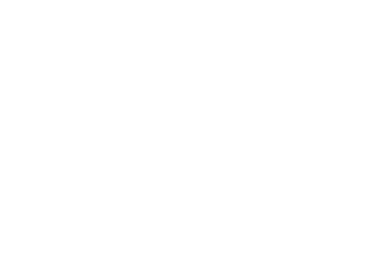

In [224]:

imgs = [Image.open(outDir + fn).convert('RGB') for fn in file_names]



def build_gif(imgs, show_gif=True, save_gif=True, title=''):
 
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
 
    ims = map(lambda x: (ax.imshow(x), ax.set_title(title)), imgs)
 
    im_ani = animation.ArtistAnimation(fig, ims, interval=800, repeat_delay=0, blit=False)
 
    if save_gif:
        im_ani.save('animation.gif', writer='imagemagick')
 
    if show_gif:
        plt.show()
 
    return

build_gif(imgs)

## Ivezic+2003 : g-r vs r 

In [192]:
np.ravel(data.colnames)

array(['col0', 'uN', 'uchi2DOF', 'uchi2R', 'umuFull', 'upsfMeanErr',
       'upsfMean_corr', 'gN', 'gchi2DOF', 'gchi2R', 'gmuFull',
       'gpsfMeanErr', 'gpsfMean_corr', 'rN', 'rchi2DOF', 'rchi2R',
       'rmuFull', 'rpsfMeanErr', 'rpsfMean_corr', 'iN', 'ichi2DOF',
       'ichi2R', 'imuFull', 'ipsfMeanErr', 'ipsfMean_corr', 'zN',
       'zchi2DOF', 'zchi2R', 'zmuFull', 'zpsfMeanErr', 'zpsfMean_corr',
       'ebv', 'objectId', 'patch', 'deepSourceId', 'extendedness', 'ra',
       'decl'], 
      dtype='<U13')

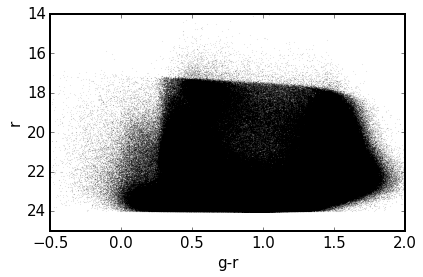

In [197]:
%matplotlib inline 

g = data['gpsfMean_corr'].data.data
r = data['rpsfMean_corr'].data.data

m1 = r < 24
m2 = data['extendedness'] == 0 # choose only stars ...

m = m1 & m2 

gr = g[m]-r[m]
r = r[m]
plt.scatter(gr,r, s=0.001)
plt.xlim(-0.5,2)
plt.ylim(14,25)
plt.xlabel('g-r', fontsize=15)
plt.ylabel('r', fontsize=15)
plt.gca().invert_yaxis()
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

plt.savefig('../data_products/Fig_Ivezic2003/Fig_2_test.png')
plt.show()



In [102]:
outDir

'/Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_Sesar2007/2017-03-10/'